# Работа с временными рядами

Отличная статья про временные ряды от Дмитрия Сергеева - https://habr.com/company/ods/blog/327242/. 

**Временной ряд** - последовательно измеренные через некоторые (зачастую равные) промежутки времени данные.

Обычно в задачах анализа данных предполагается независимость наблюдений. При работе с временными рядами мы строим свой прогноз на основе наблюдений из прошлого.

Компоненты временного ряда:
- Тренд - систематическая линейная или нелинейная компонента, изменяющаяся во времени.
- Сезонность - периодические колебания уровней временного ряда внутри года (например).
- Цикл - периодические колебания, как правило, больше, чем один сезоннный период, не имеют определенной продолжительности.
- Ошибка - непрогнозируемая компонента.
- Уровень - среднее значение временного ряда.

<img width = '800px' src="images/lesson_10/tss.png">

In [1]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

Датасет ежечасного потребления электроэнергии за последние 10 лет американской компании AEP в мегаваттах.

https://www.kaggle.com/robikscube/hourly-energy-consumption#AEP_hourly.csv

In [2]:
energy_consumption = pd.read_csv('files/lesson_10/AEP_hourly.csv', sep =',')
energy_consumption.head(2)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0


In [3]:
energy_consumption.sort_values('Datetime',axis = 0,inplace =True)
energy_consumption = energy_consumption.iloc[-30000:]
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption.Datetime,format='%Y-%m-%d %H:%M:%S') 
energy_consumption.index  = energy_consumption.Datetime
energy_consumption.drop('Datetime', axis = 1, inplace = True)
energy_consumption.head(2)

,AEP_MW
Datetime,
2015-03-02 00:00:00,15867.0
2015-03-02 01:00:00,15444.0


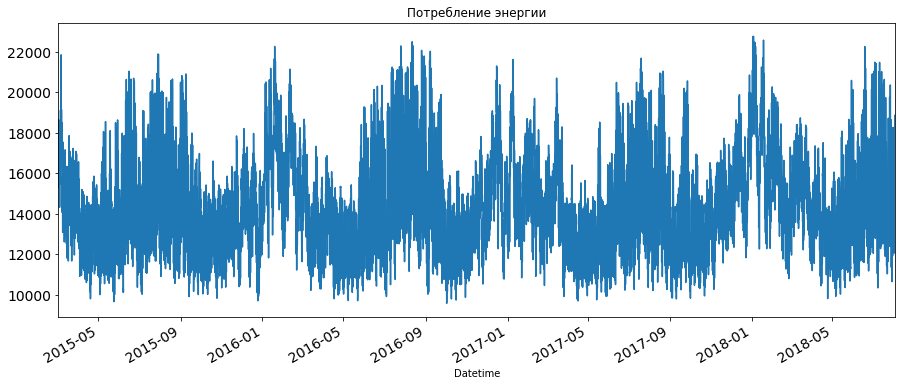

In [4]:
energy_consumption.AEP_MW.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)

### **Компоненты временного ряда**

Наш временной ряд раскладывается на отдельные компоненты, работая по отдельности с каждой из них будет проще строить прогноз. 

$Y_t = f(Trend, Seasonality,Cycle,Reminder) $

<img width = '500px' src="images/lesson_10/paintings.jpg">

Отдельные компоненты временного ряда очень похожи на краски, которые смешиваются и получается определенный цвет (наш исходный временной ряд).

##### 1. Тренд

Тренд можно извлечь с помощью скользящей средней по исходному временному ряду. 

$ MA =  \frac{1} {2m} \sum_{i=-1}^m (Y_{t+i}) $

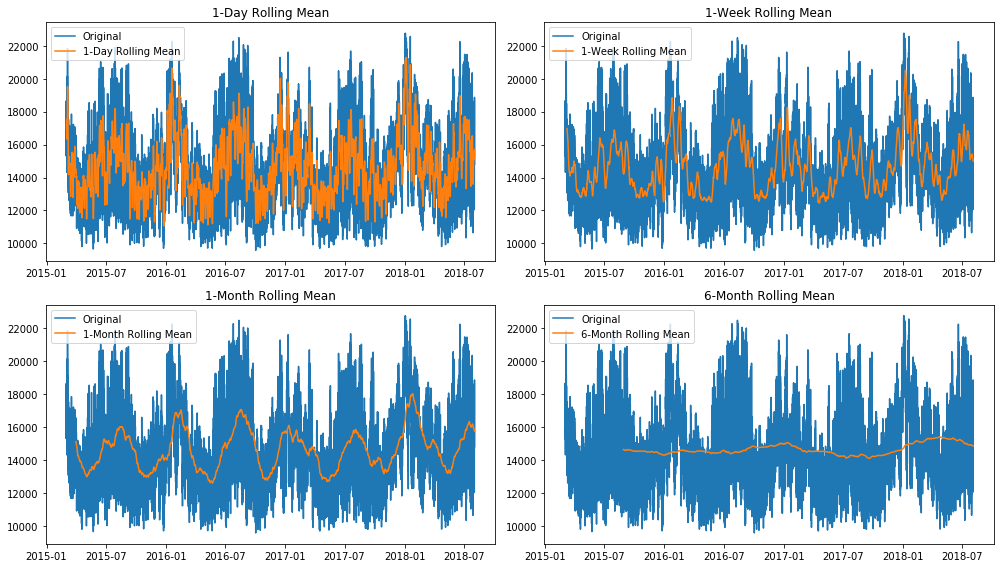

In [7]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 24
axes[0][0].plot(energy_consumption.index, energy_consumption, label='Original')
axes[0][0].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Day Rolling Mean')
axes[0][0].set_title("1-Day Rolling Mean")
axes[0][0].legend(loc='best')

window = 24*7
axes[0][1].plot(energy_consumption.index, energy_consumption, label='Original')
axes[0][1].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Week Rolling Mean')
axes[0][1].set_title("1-Week Rolling Mean")
axes[0][1].legend(loc='best')

window = 24*30
axes[1][0].plot(energy_consumption.index, energy_consumption, label='Original')
axes[1][0].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[1][0].set_title("1-Month Rolling Mean")
axes[1][0].legend(loc='best')

window = 24*30*6
axes[1][1].plot(energy_consumption.index, energy_consumption, label='Original')
axes[1][1].plot(energy_consumption.index, energy_consumption.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1][1].set_title("6-Month Rolling Mean")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

Чтобы извлечь тренд нужно использовать окно равное сезонности временного ряда (сезонность можно понять как визуально по графику, так и с помощью рядов Фурье - https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html).

#### 2. Сезонность

In [9]:
rcParams['figure.figsize'] = 20, 5
energy_consumption['year'] = energy_consumption.index.year
energy_consumption['month'] = energy_consumption.index.month
energy_consumption_pivot = pd.pivot_table(energy_consumption, values = "AEP_MW", columns = "year", index = "month")

In [11]:
energy_consumption.head(2)

,AEP_MW,year,month
Datetime,,,
2015-03-02 00:00:00,15867.0,2015,3
2015-03-02 01:00:00,15444.0,2015,3


In [12]:
energy_consumption_pivot.head(2)

year,2015,2016,2017,2018
month,,,,
1,NaN,16760.747312,15566.197581,17594.87500
2,NaN,15895.386494,14665.684524,15276.66369


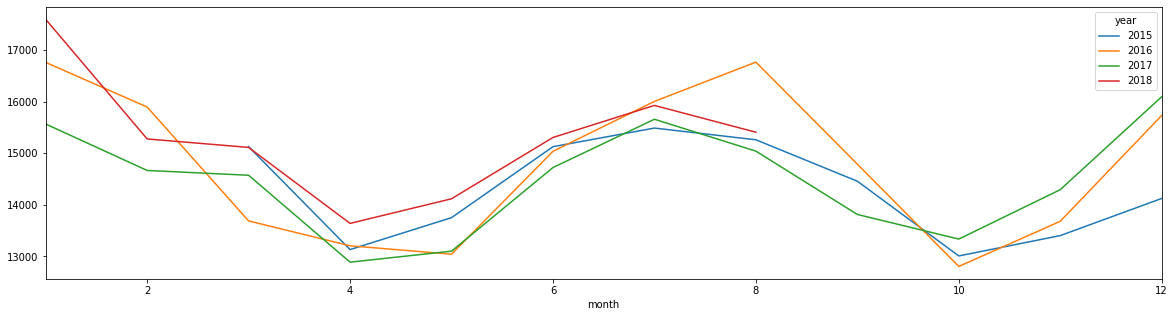

In [13]:
energy_consumption_pivot.plot()

##### 3. Остатки

То, что осталось после удаления сезонности и тренда, остаки должны напоминать белый шум.

**Декомпозиция временного ряда**

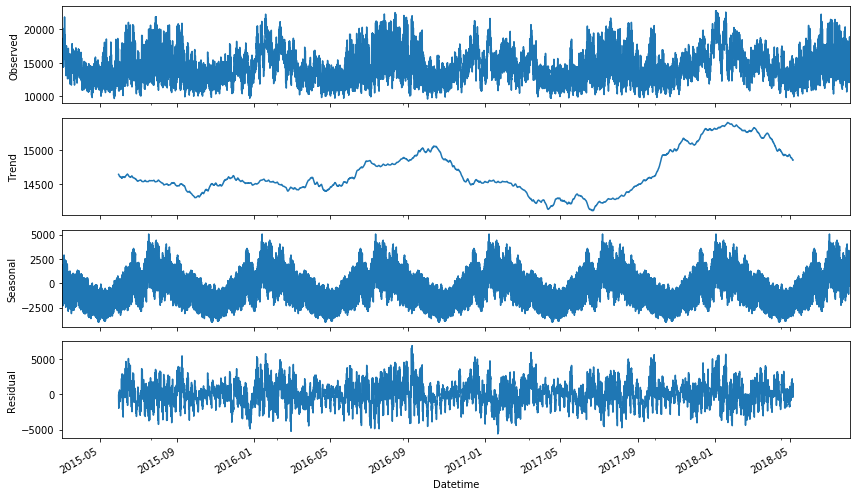

In [20]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(energy_consumption.AEP_MW, model='additive',freq= 24*30*6)
result.plot()
plt.show()

Модели, с помощью которых можно описать временной ряд.

<img width = '700px' src="images/lesson_10/methods.png">

Исходный временной ряд.

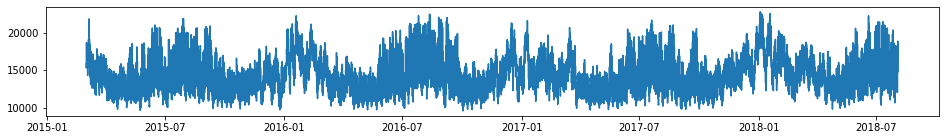

In [23]:
plt.figure(figsize=(16,2))

plt.plot(energy_consumption.AEP_MW)
plt.show()

Плавающее среднее.

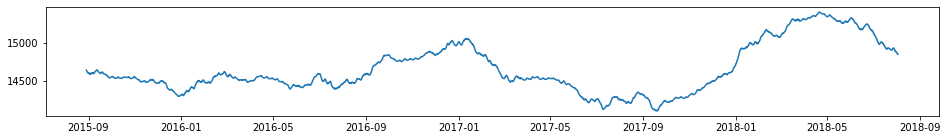

In [27]:
plt.figure(figsize=(16,2))

MA = energy_consumption.AEP_MW.rolling(window=24*30*6).mean()

plt.plot(MA)
plt.show()

Убираем тренд.

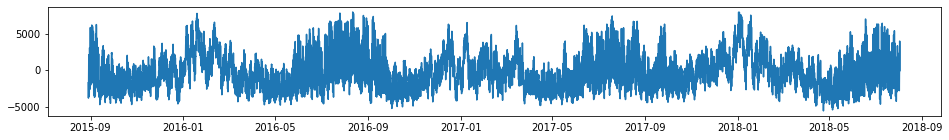

In [34]:
detrend_ = energy_consumption.AEP_MW - MA
# detrend_ = energy_consumption.AEP_MW / MA

plt.figure(figsize=(16,2))

plt.plot(detrend_)
plt.show()

Нормализуем по дням сезона

In [43]:
def seasonal_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [56]:
s_a = seasonal_mean(detrend_, 24*30*6)
s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 24*30*6 + 1).T[:nobs]

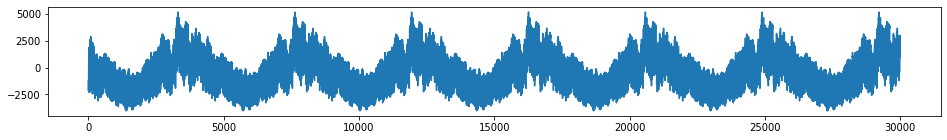

In [55]:
plt.figure(figsize=(16,2))

plt.plot(seasonal)
plt.show()

Остатки

In [57]:
residuals = energy_consumption.AEP_MW - MA - seasonal

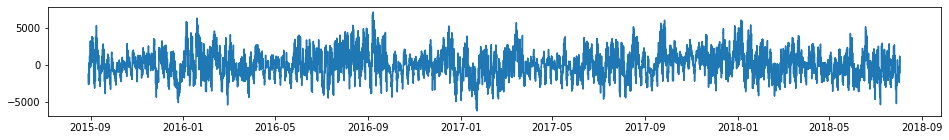

In [58]:
plt.figure(figsize=(16,2))

plt.plot(residuals)
plt.show()

### Предсказание по временному ряду

##### Наивный подход

"Завтра = вчера"

${Y}_{t} =  Y_{t-n}$

##### Предсказание плавающем средним

Новое значение будет вычисляться на основе среднего за конкретный период.

${Y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} Y_{t-n}$

In [11]:
np.average(energy_consumption[-24:])

5914.055555555556

Можем предсказывать лишь только на один день вперед.

##### Взвешенное среднее

${Y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n Y_{t+1-n}$

In [12]:
np.sum(energy_consumption.AEP_MW[-4:] * [0.1,0.2,0.3,0.4])

15843.300000000001

##### Экспоненциальное сглаживание


https://www.youtube.com/watch?v=Fqge2HDH2Co

Для прогноза будем учитывать все наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные.

${F}_{t} = \alpha \cdot Y_t + (1-\alpha) \cdot L_{t-1} $

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [17]:
#Простой пример
series_val = [1,2,3,4,5,6]

result = [series_val[0]]

#alpha - насколько сильно мы не хотим помнить, что было в прошлом
alpha = 0.9
# alpha = 0.1

for n in range(1, len(series_val)):
#     print(series_val[n])
    result.append(alpha * series_val[n] + (1 - alpha) * result[n-1])
    
result   

[1, 1.9, 2.89, 3.8890000000000002, 4.8889, 5.88889]

Попробуем интуитивно понять, что за этим стоит, раскроем скобки:

${F}_{t} = \alpha \cdot Y_t + L_{t-1}-\alpha L_{t-1} $

${F}_{t} = L_{t-1} + \alpha ( Y_t - L_{t-1}) $ -> ${F}_{t} = L_{t-1} + \alpha e_t $

То есть мы строим свой прогноз как бы учитывая ошибку, которую мы сделали на предыдущем шаге.

<img width = '500px' src="images/lesson_10/ses.png">

Две крайности:
- $ \alpha = 0$ -> прогноз - просто среднее

- $ \alpha = 1$ -> наивное предсказание

In [18]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [19]:
fit = SimpleExpSmoothing(np.asarray(energy_consumption.AEP_MW)).fit(smoothing_level=l=0.7,optimized=False)
fit.forecast(0)

array([15261.44014523])

Все рассмотренные способы не очень подходят для прогнозирования данных с высоким разбросом, не учитываются компоненты временного ряда, могут подойти для прогнозирования на **один** шаг вперед либо для сглаживания.

##### Двойное экспоненциальное сглаживание

Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

У нас есть следующие компоненты:

- линейное уравнение для построения прогноза    
${F}_{t} = {F}_{tT} + {F}_{tL}$    
- уравнение уровня    
${F}_{tL} = \alpha \cdot Y_t + (1-\alpha) \cdot (L_{t-1} + T_{t-1}) $
- уравнение тренда    
${F}_{tT} = \beta \cdot (L_t - L_{t-1}) + (1-\beta)T_{t-1} $

Итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [71]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-1]

In [72]:
double_exponential_smoothing(energy_consumption.AEP_MW, 0.4, 0.2)

15304.944514776882

In [73]:
fit = Holt(np.array(energy_consumption.AEP_MW)).fit(smoothing_level = 0.4,smoothing_slope = 0.2)
fit.forecast(2)[1]

15304.94451477688

##### Тройное экспоненциальное сглаживание

Учитывает в том числе и сезонность.

- уравнение тренда    
${F}_{tT} = \beta \cdot (L_t - L_{t-1}) + (1-\beta)T_{t-1} $

- уравнение уровня    
${F}_{tL} = \alpha \cdot Y_t/(S_{t-M}) + (1-\alpha) \cdot (L_{t-1} + T_{t-1}) $

- уравнение сезонности    
${F}_{tS} = \gamma \cdot Y_t/(L_t) + (1-\gamma) \cdot (S_{t-M}) $


Попробуем предсказать потребление энергии за последнюю неделю, отделим train и test.

In [103]:
train = energy_consumption.AEP_MW.iloc[:-24*7]
test = energy_consumption.AEP_MW.iloc[-24*7:]

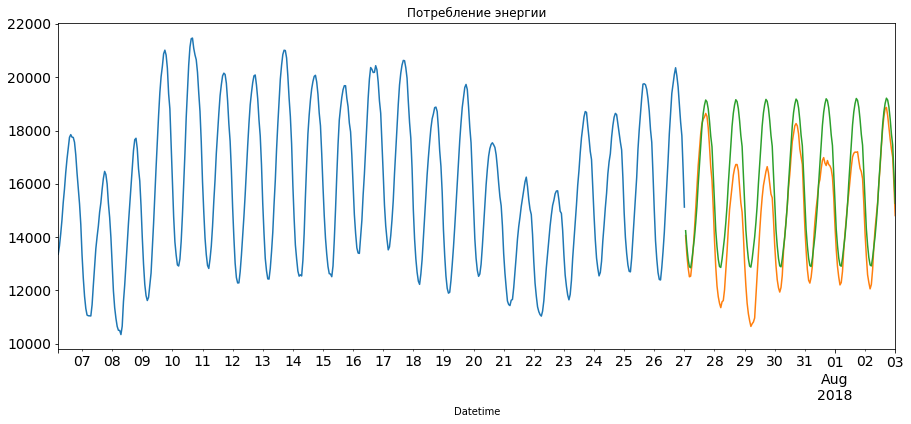

In [104]:
train.iloc[-500:].plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)
test.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)
forecast = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
forecast = pd.Series(fit1.forecast(len(test)))
forecast.index = test.index
forecast.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14)


In [110]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(test, forecast)

2024877.2333966487

Относительная ошибка - хорошая метрика для бизнеса

In [113]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [114]:
mean_absolute_percentage_error(test, forecast)

8.000726226053759

### Валидация для временного ряда

В реальных задачах у нас нет возможности "заглянуть в будущее", поэтому наша валидация должна полностью повторять ситуацию на тесте.

<img width = '700px' src="images/lesson_10/validation.png">

In [160]:
from sklearn.model_selection import TimeSeriesSplit 
errors = []
    
tscv = TimeSeriesSplit(n_splits=3) 

for train, test in tscv.split(energy_consumption.AEP_MW):

    model = ExponentialSmoothing(np.asarray(energy_consumption.AEP_MW.iloc[train]) ,seasonal_periods=24 , seasonal='add').fit()
    
    forecast = pd.Series(model.forecast(len(test)))
    actual = energy_consumption.AEP_MW.iloc[test]
    error = mean_absolute_percentage_error(actual.values, forecast.values)
    errors.append(error)

In [162]:
errors

[22.0624847097697, 11.180526654479719, 11.579562327481813]

In [163]:
np.mean(errors)

14.940857897243745

### Эконометрический подход

Перед тем как применять статистическую модель для временного ряда необходимо убедиться, что ряд стационарен.

**Стационарность** — свойство процесса не менять свои характеристики со временем. Временной ряд стаицонарен, если его свойства не зависят от времени.

- постоянство матожидания

<img width = '500px' src="images/lesson_10/stat1.png">

- постоянство дисперсии (она же гомоскедастичность)

<img width = '500px' src="images/lesson_10/stat2.png">

- независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями)

<img width = '500px' src="images/lesson_10/stat3.png">

Зачем?

- По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих.

Как определить стационарность?

- визуально изучить плавающее среднее, плавающее стандартное отклонеение

- применить статистический тест 

In [62]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [6]:
sample_data = energy_consumption.AEP_MW[-1000:]

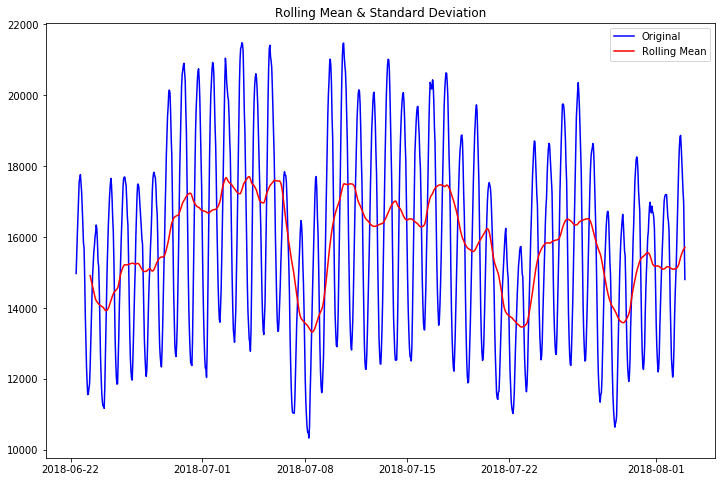

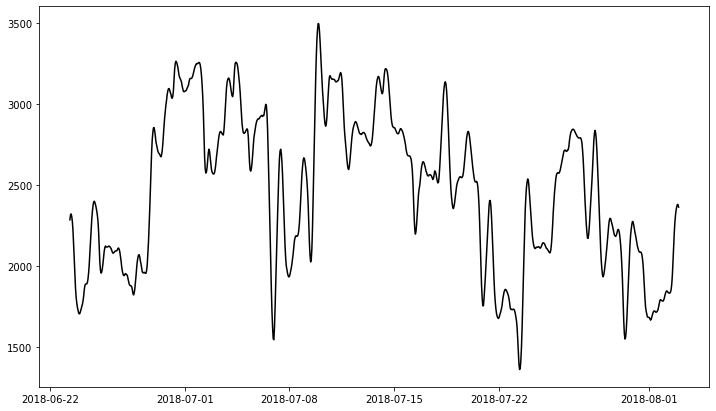

Results of Dickey-Fuller Test:
p-value = 0.0894. The series is likely non-stationary.
Test Statistic                  -2.617696
p-value                          0.089395
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [63]:
test_stationarity(sample_data)

Временной ряд **нестационарен**.

Подходы для того чтобы сделать временной ряд стационарным:
- в случае непостоянства дисперсии - логарифмирование либо преобразование Бокса-Кокса;
- почти всегда помогает дифференцирование (переход к попарным разностям ряда): стабилизирует среднее значение ряда, может применяться неоднократно, выделяют также сезонное дифференцирование - попарная разность по сезонам.

**Корреляция** (Пирсона) - сила линейной взаимосвязи между двумя случайными величинами.

Формула выборочной корреляции:
    
 $r_{X_1, X_2}  =\frac{ \sum_{i=1}^n (X_{1i} - \overline{X_1})(X_{2i} - \overline{X_2})}  {\sqrt{\sum_{i=1}^n (X_{1i} - \overline{X_1})^2\sum_{i=1}^n (X_{2i} - \overline{X_2})^2}} $   
 
 **Автокорреляция** (последовательная корреляция) - корреляция между последовательными показателями, упорядоченными во времени.

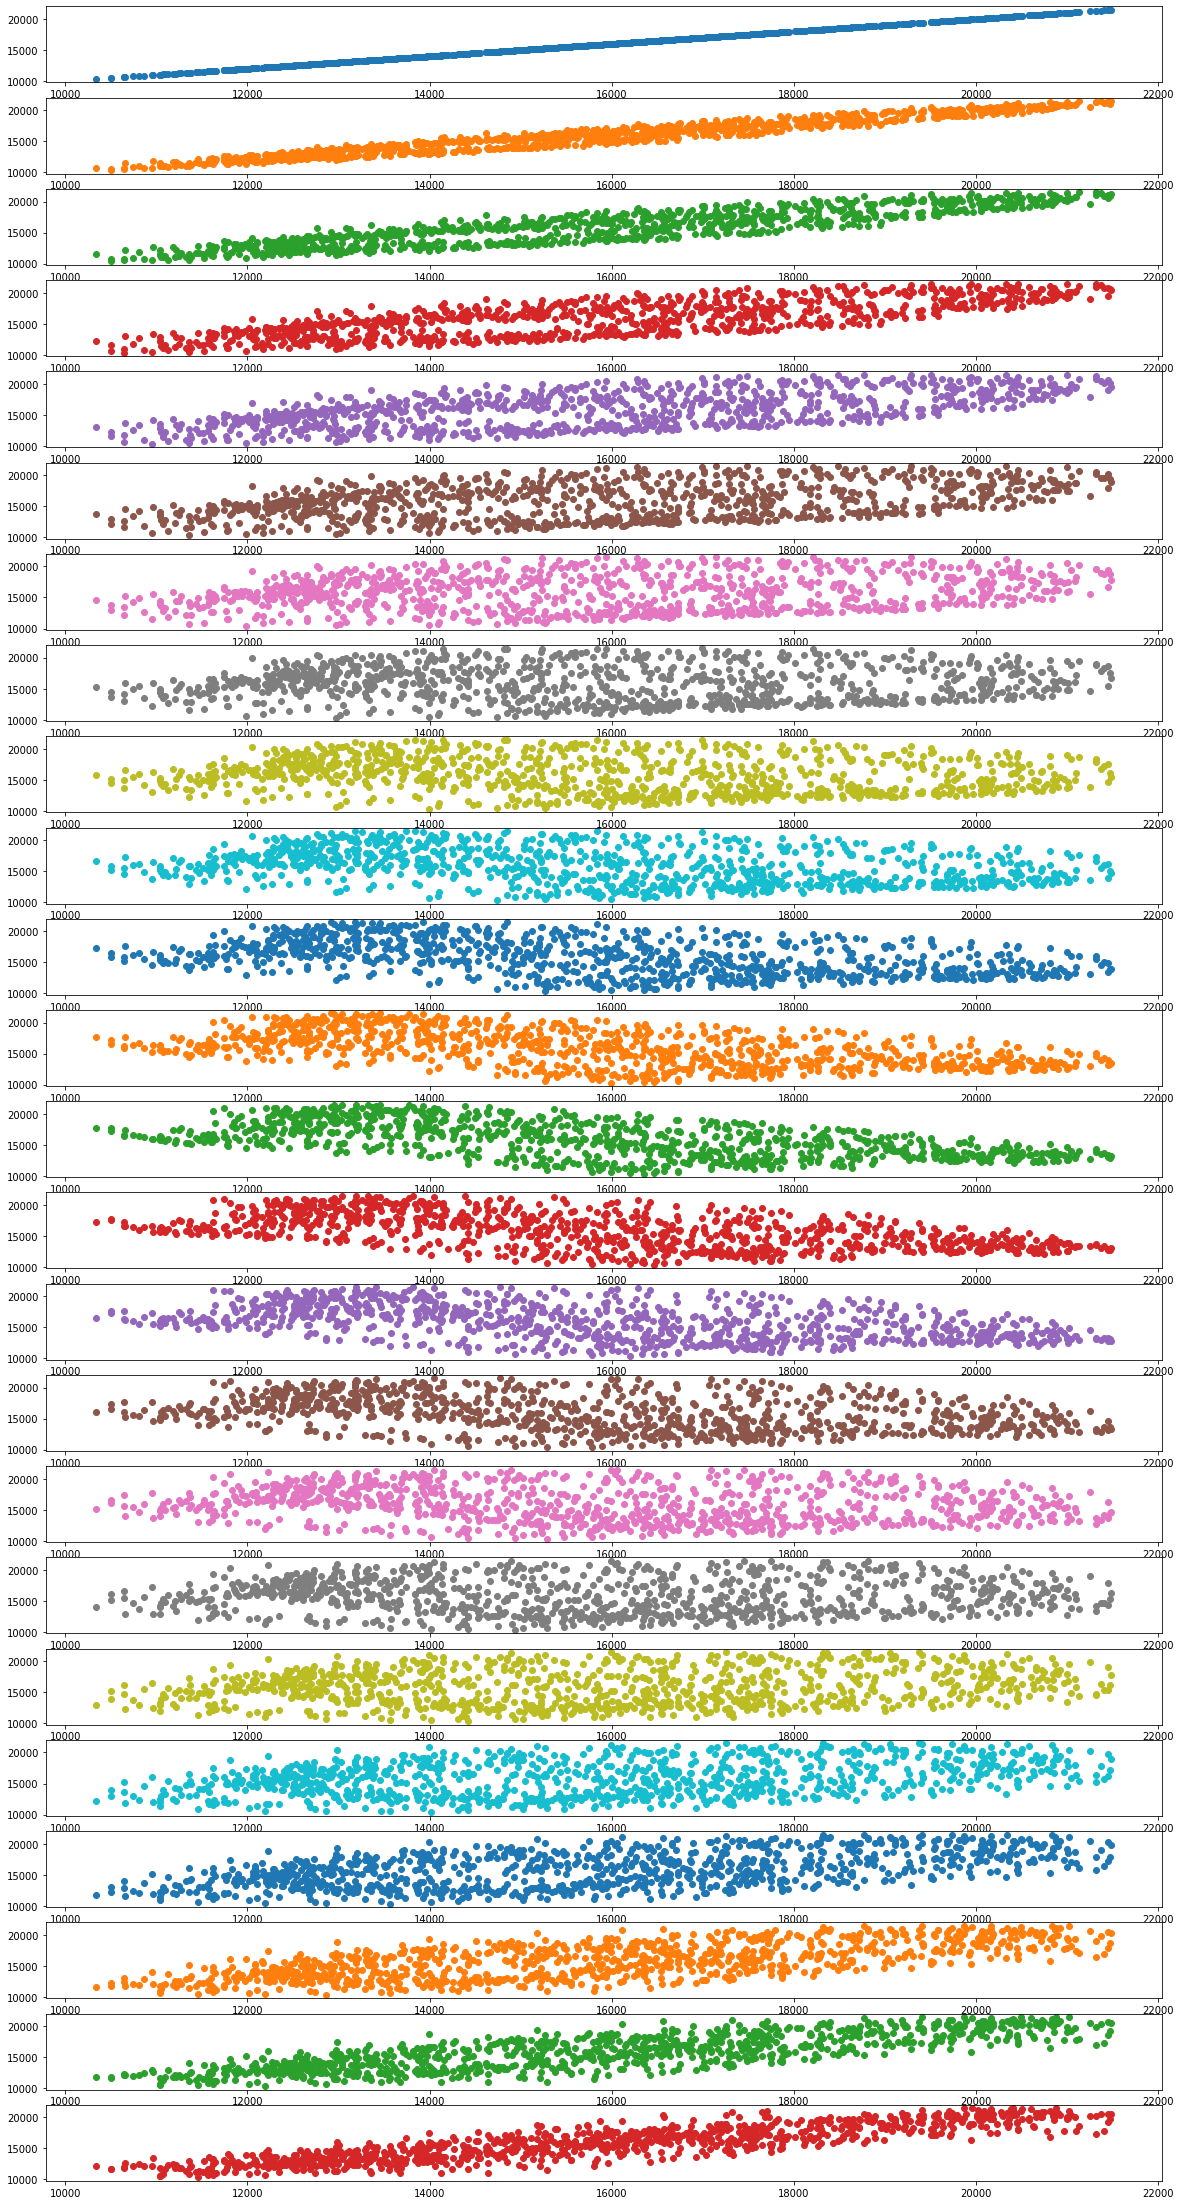

In [181]:
fig, axes = plt.subplots(24,1,figsize = (20,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(sample_data,sample_data.shift(-k),'o')


plt.show()

Автокорреляция - корреляция между исходным рядом и его версией, который сдивнут на некий лаг **t** (лаг автокорреляции).

<img width = '500px' src="images/lesson_10/autocor.png">

### ARIMA

**ARIMA** - AR (Авторегрессия) + I(Интегрирование) + MA(Скользящее среднее). 

Будем строить модель SARIMA, модель, учитывающая сезонность ряда.

Чтобы построить модель нам нужно знать ее порядок, состоящий из 6-х параметров:

- p,P — порядок компоненты AR
- d,D — порядок интегрированного ряда
- q,Q — порядок компонетны MA

*Для p,P и q,Q надо изучить авторкорреляционную(ACF) и частную автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q и Q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.
PACF поможет нам определить p и P, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.*

<img width = '700px' src="images/lesson_10/arima.png">

##### 1. Интегрирование

Необходимо избавиться от сезонности.

<img width = '600px' src="images/lesson_10/diff.png">

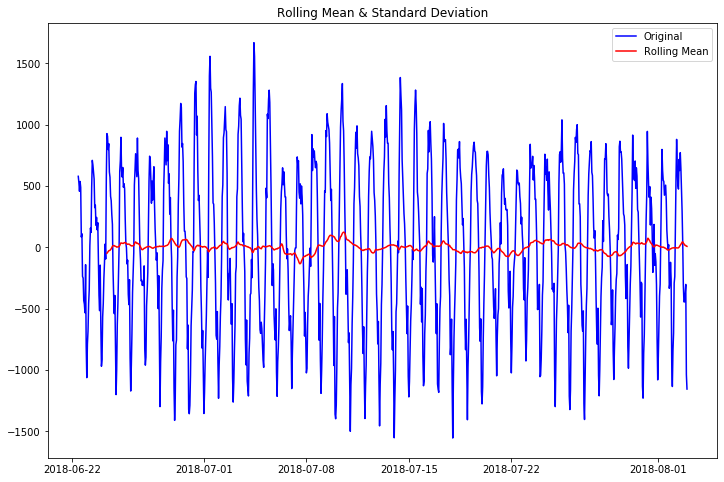

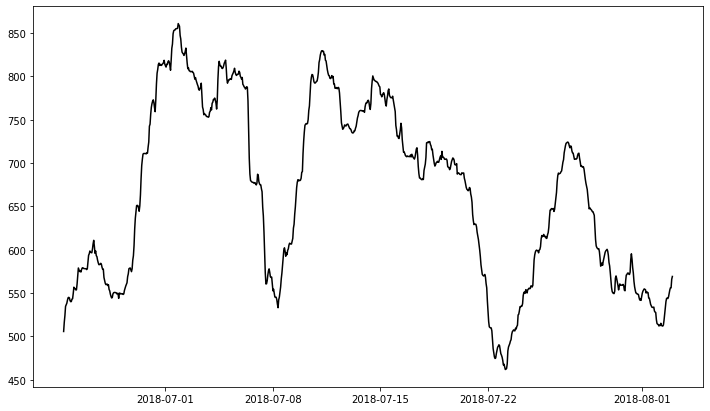

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.874538e+00
p-value                        3.182281e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64


In [66]:
rcParams['figure.figsize'] = 12, 7
sample_data_diff = sample_data - sample_data.shift(1)
sample_data_diff.dropna(inplace = True)
test_stationarity(sample_data_diff, window = 48)

**Компонент d = 1, D = 0, так как сезонное дифференцирование мы не делали.**

Все же, если ряд сезонный, то рекомендуется начинать именно с сезонного дифференцирования (D).

##### 2. Авторегрессия (AR - компонент)

Надо понять влияние прошлых периодов на текущий период.

<img width = '500px' src="images/lesson_10/auto.png">

Модель - линейная комбинация **p** предыдущих значений ряда, шумовой компоненты и константы.

Чтобы определить параметр p (найти его приближение), необходимо обратиться к Частной АвтоКорреляционной Функции.

**Частичная автокорреляционная функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. 

<img width = '400px' src="images/lesson_10/partial_autocor.png">

Автокорреляция показывает зависимость между y4 и y1, при этом игнорируя эффект от изменения y2 и y3. А частная автокорреляция также показывает эффект между y4 и y1, при этом учитывая, что эффект от y2 и y3 отсутсвует, то есть убирает эффекты y2 и y3.

Рекомендации к подбору первоначальных приближений:

P(p) - номер последнего сезонного (несезонного) лага, при котором частная автокорреляция значима (персекается граница доверительного интервала), при этом стоит учитывать, что большое число компонентов ведет к увеличению сложности модели и переобучению, если Р > 0, то p не может быть больше сезонного лага.

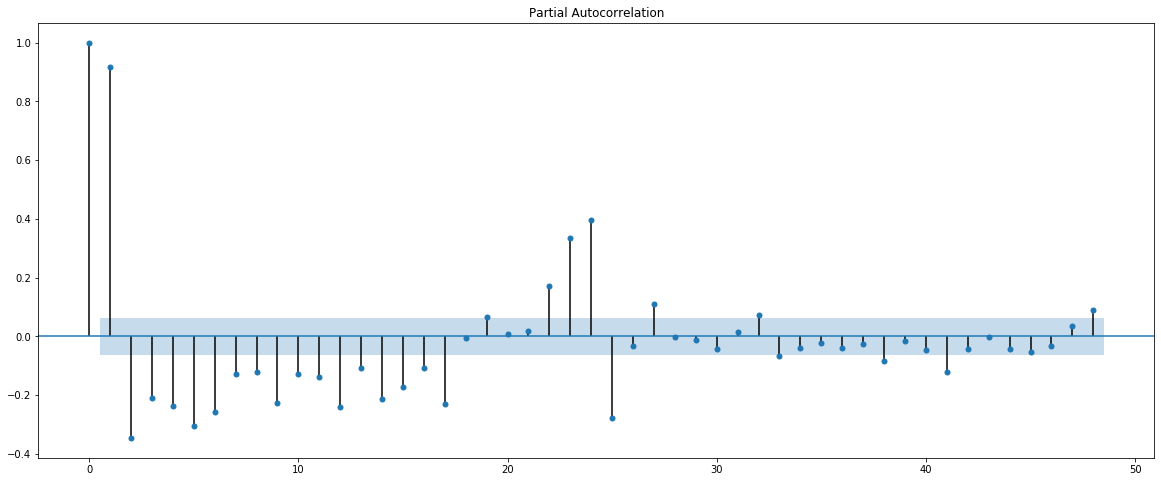

In [67]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(sample_data_diff.values, lags=48,ax = ax)
plt.show()

##### 3. Скользящее среднее (MA - компонент)

Будем строить модель, как линейную комбинацию **q** последних значений шумовой компоненты. Модель, где используется зависимость между наблюдением и остаточными ошибками от скользящей средней модели применительно к запаздывающим наблюдениям.

<img width = '500px' src="images/lesson_10/ma.png">

Q(q) - номер последнего сезонного (несезонного) лага, при котором автокорреляция значима, если Q > 0, то q не может быть больше сезонного лага.

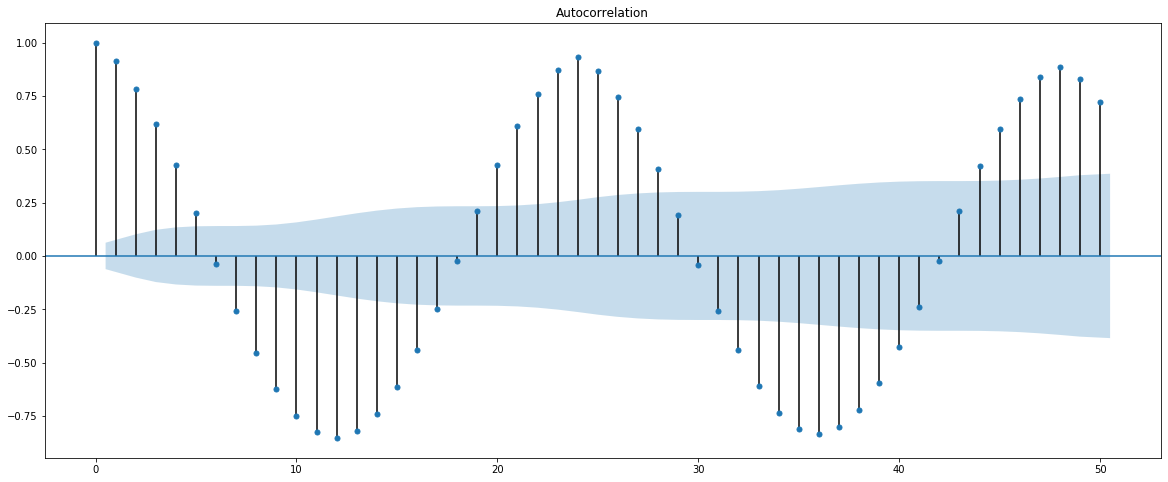

In [68]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(sample_data_diff.values, lags=50,ax = ax)
plt.show()

##### 4. Построение прогноза

In [69]:
d = 1
D = 0
s = 24

ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=0
Qs = range(0, 2)

In [70]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [71]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sample_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 8.66 s


In [72]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                             AEP_MW   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -6603.592
Date:                            Sun, 17 Nov 2019   AIC                          13217.183
Time:                                    13:49:01   BIC                          13241.717
Sample:                                06-22-2018   HQIC                         13226.508
                                     - 08-03-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5933      0.034     17.463      0.000       0.527       0.660
ma.L1          0.1807      0.042   

Изучим остатки модели, действительно ли они представляют белый шум.

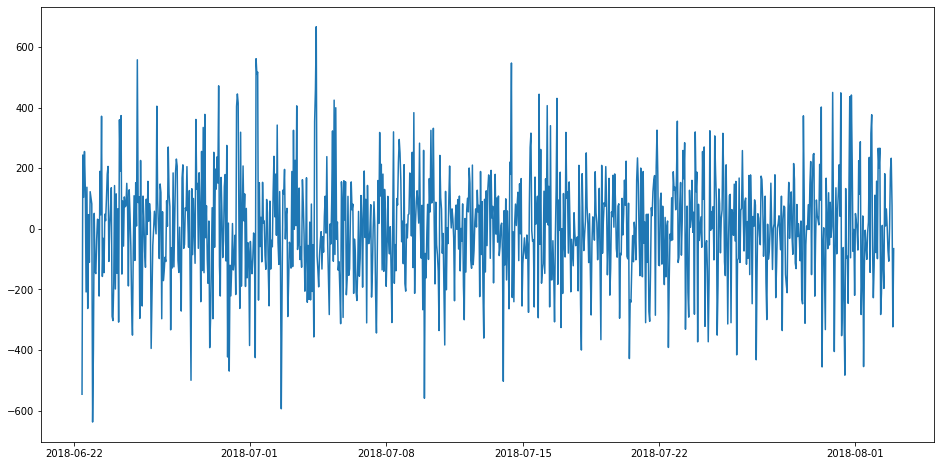

In [73]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

In [74]:
stat_test = sm.tsa.adfuller(best_model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -11.925879929780741
p-value:  4.908571607749759e-22
Critical values:  {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}
единичных корней нет, ряд стационарен


In [75]:
forecast = best_model.predict(start = sample_data.shape[0], end = sample_data.shape[0]+24)

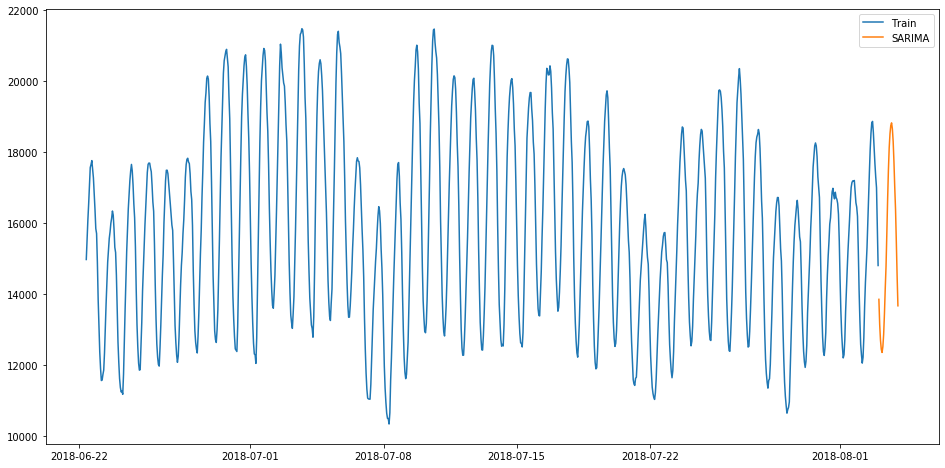

In [376]:
plt.figure(figsize=(16,8))
plt.plot(sample_data, label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

### Линейные модели

Иногда проще всего будет просто построить линейную модель, включив туда фичи, основанные на времени:
    - лаговые фичи
    - статистики по лаговым фичам
    - час, день, минута
    - праздники, выходные
    - и т.д.

In [4]:
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [7]:
sample_data_df = pd.DataFrame(sample_data)

date_rng = pd.date_range(start=sample_data_df.index[-1].date(), end=sample_data_df.index[-1].date() + timedelta(days=0, hours=25, seconds=0), freq='H')
test_period = pd.DataFrame(date_rng[1:], columns = ['datetime'])
test_period.index = test_period.datetime
test_period.drop('datetime', axis = 1, inplace = True)

sample_data_df = pd.concat((sample_data_df,test_period), axis = 0)

In [342]:
sample_data_df.head(5)

,AEP_MW
2018-06-22 09:00:00,14978.0
2018-06-22 10:00:00,15557.0
2018-06-22 11:00:00,16087.0
2018-06-22 12:00:00,16544.0
2018-06-22 13:00:00,17081.0


In [384]:
# лаговые фичи
lag_period = 24
features = []
for period_mult in range(1,10,1):
    sample_data_df["lag_period_{}".format(period_mult)] = sample_data_df.AEP_MW.shift(period_mult*lag_period)
    features.append("lag_period_{}".format(period_mult))

# лаговые статистики
sample_data_df['lagf_min'] = sample_data_df[features].min(axis = 1)
sample_data_df['lagf_max'] = sample_data_df[features].max(axis = 1)
sample_data_df['lagf_mean'] = sample_data_df[features].mean(axis = 1)
sample_data_df['lagf_median'] = sample_data_df[features].median(axis = 1)    

features.extend(['lagf_min', 'lagf_max', 'lagf_mean', 'lagf_median'])

C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [385]:
train = sample_data_df.iloc[:-24].dropna()
test = sample_data_df.iloc[-24:]

model = LinearRegression()
model.fit(train[features],train['AEP_MW'] )
forecast = model.predict(test[features])

In [386]:
test['AEP_MW'] = forecast

C:\Users\k.izmailov\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


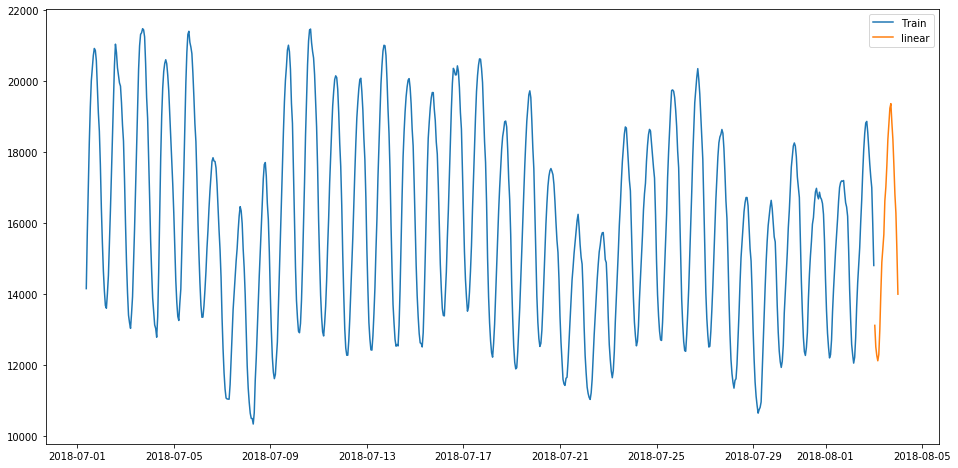

In [387]:
plt.figure(figsize=(16,8))
plt.plot(train.AEP_MW, label='Train')
plt.plot(test.AEP_MW, label='linear')
plt.legend(loc='best')
plt.show()

In [388]:
def plotCoefficients(model,train_features):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, train_features)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

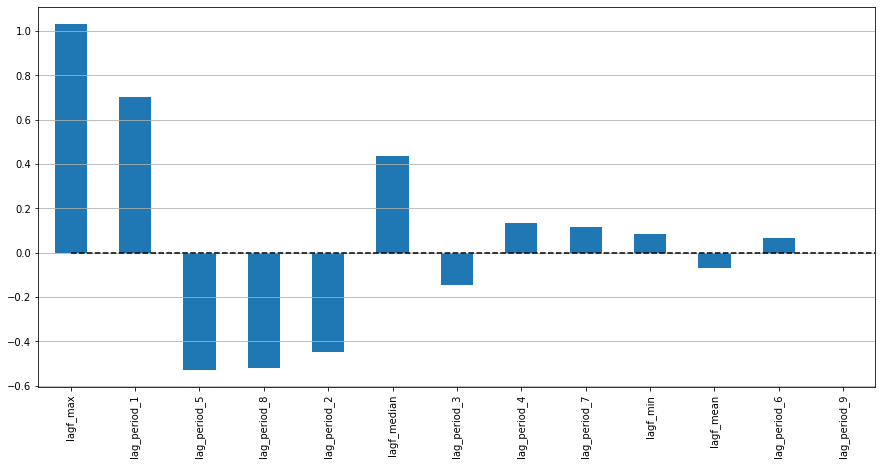

In [389]:
plotCoefficients(model,features)

In [1]:
# !pip install fbprophet строит фичи, лаги и т. д.